# Feature Exploratory Data Analysis (EDA)

This notebook explores the engineered customer features and their relationships with churn.

## Objectives:
- Visualize feature distributions
- Analyze RFM patterns
- Identify statistically significant features
- Understand customer segments
- Generate insights for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create visualizations directory
import os
os.makedirs('../visualizations/eda', exist_ok=True)

print('✓ Libraries loaded successfully')

✓ Libraries loaded successfully


## 1. Load Data

In [2]:
# Load customer features
df = pd.read_csv('../data/processed/customer_features.csv')

print(f'Dataset Shape: {df.shape}')
print(f'\nChurn Rate: {df["Churn"].mean()*100:.2f}%')
print(f'Churned Customers: {df["Churn"].sum():,}')
print(f'Active Customers: {(1-df["Churn"]).sum():,}')

df.head()

Dataset Shape: (3213, 38)

Churn Rate: 42.20%
Churned Customers: 1,356
Active Customers: 1,857


,Customer ID,Recency,Frequency,TotalSpent,AvgOrderValue,UniqueProducts,TotalItems,AvgDaysBetweenPurchases,AvgBasketSize,StdBasketSize,...,StdPricePreference,MinPrice,MaxPrice,AvgQuantityPerOrder,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,CustomerSegment,Churn
0,12346,72,11,372.86,33.896364,26,70,19.20,6.363636,4.653444,...,1.682971,1.00,7.49,2.121212,3,4,2,9,Loyal,1
1,12349,132,1,794.52,794.520000,40,457,999.00,457.000000,0.000000,...,2.167603,0.42,7.49,11.425000,2,1,3,6,Lost,0
2,12355,110,1,437.11,437.110000,20,253,999.00,253.000000,0.000000,...,1.622503,0.42,4.95,12.650000,2,1,3,6,Lost,1
3,12358,93,2,382.13,191.065000,21,156,181.00,78.000000,18.384776,...,1.887921,1.25,6.75,7.090909,2,2,2,6,Lost,0
4,12359,78,5,1236.48,247.296000,67,426,49.25,85.200000,61.977415,...,1.694253,0.85,7.49,6.173913,2,4,4,10,At Risk,0


## 2. Churn Distribution

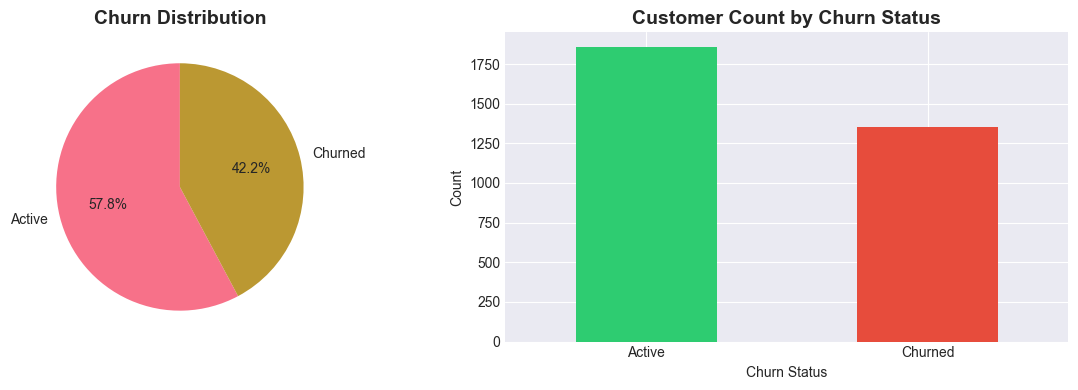

✓ Churn distribution visualized


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart
churn_counts = df['Churn'].value_counts()
axes[0].pie(churn_counts, labels=['Active', 'Churned'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Churn Distribution', fontsize=14, weight='bold')

# Bar chart
churn_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Customer Count by Churn Status', fontsize=14, weight='bold')
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Active', 'Churned'], rotation=0)

plt.tight_layout()
plt.savefig('../visualizations/eda/01_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Churn distribution visualized')

## 3. RFM Analysis

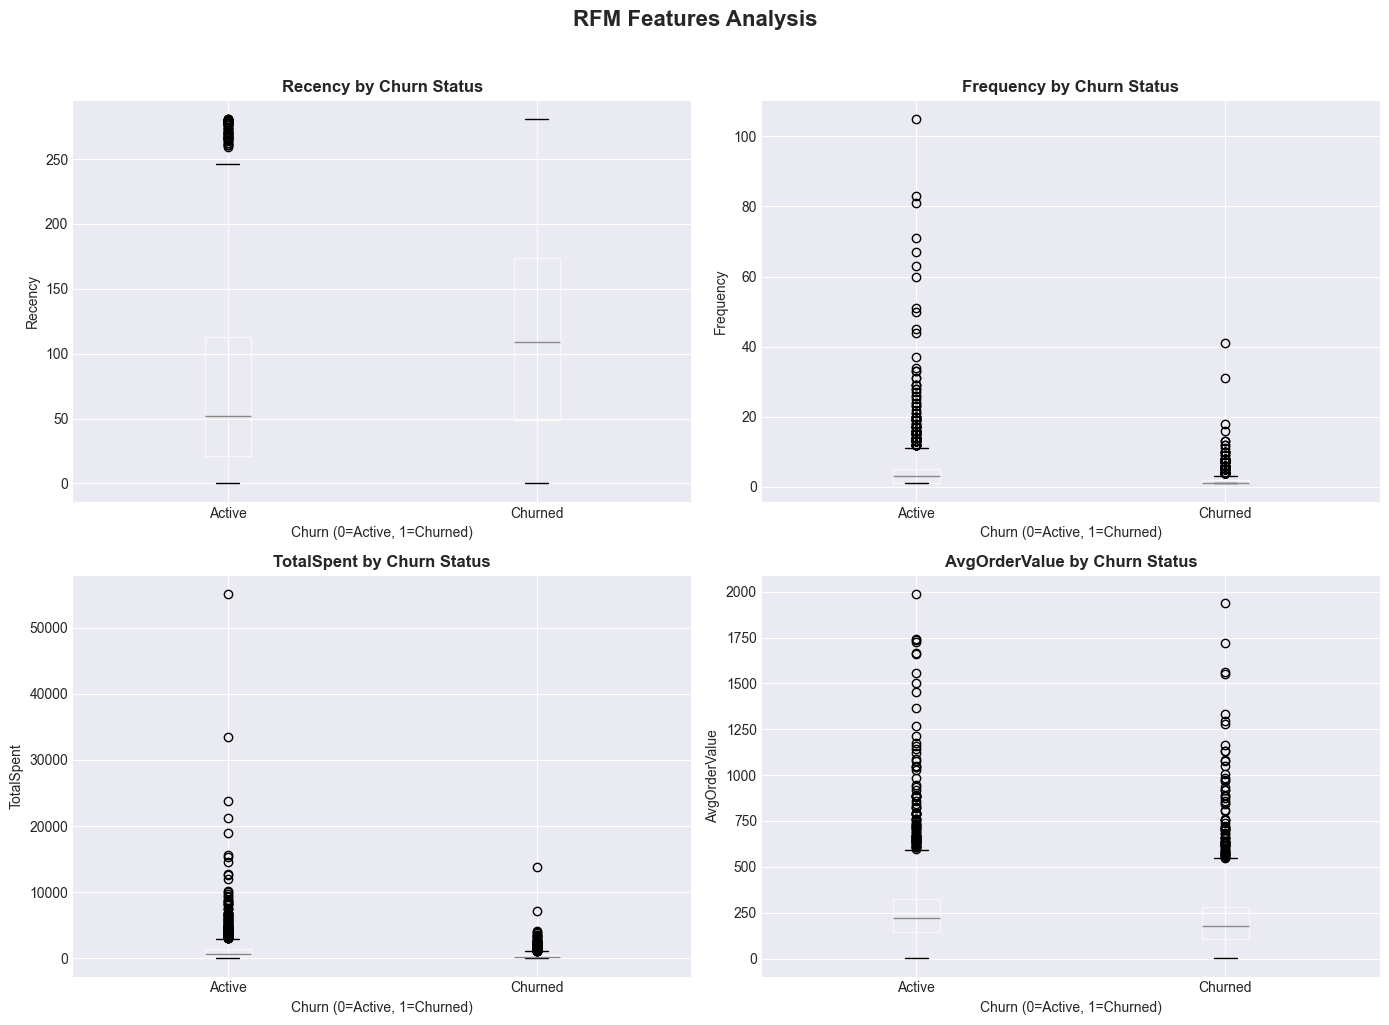

✓ RFM analysis visualized


In [4]:
# RFM boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
rfm_features = ['Recency', 'Frequency', 'TotalSpent', 'AvgOrderValue']

for idx, feature in enumerate(rfm_features):
    ax = axes[idx//2, idx%2]
    
    # Boxplot
    df.boxplot(column=feature, by='Churn', ax=ax)
    ax.set_title(f'{feature} by Churn Status', fontsize=12, weight='bold')
    ax.set_xlabel('Churn (0=Active, 1=Churned)')
    ax.set_ylabel(feature)
    plt.sca(ax)
    plt.xticks([1, 2], ['Active', 'Churned'])
    
plt.suptitle('RFM Features Analysis', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../visualizations/eda/02_rfm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ RFM analysis visualized')

## 4. Correlation Heatmap

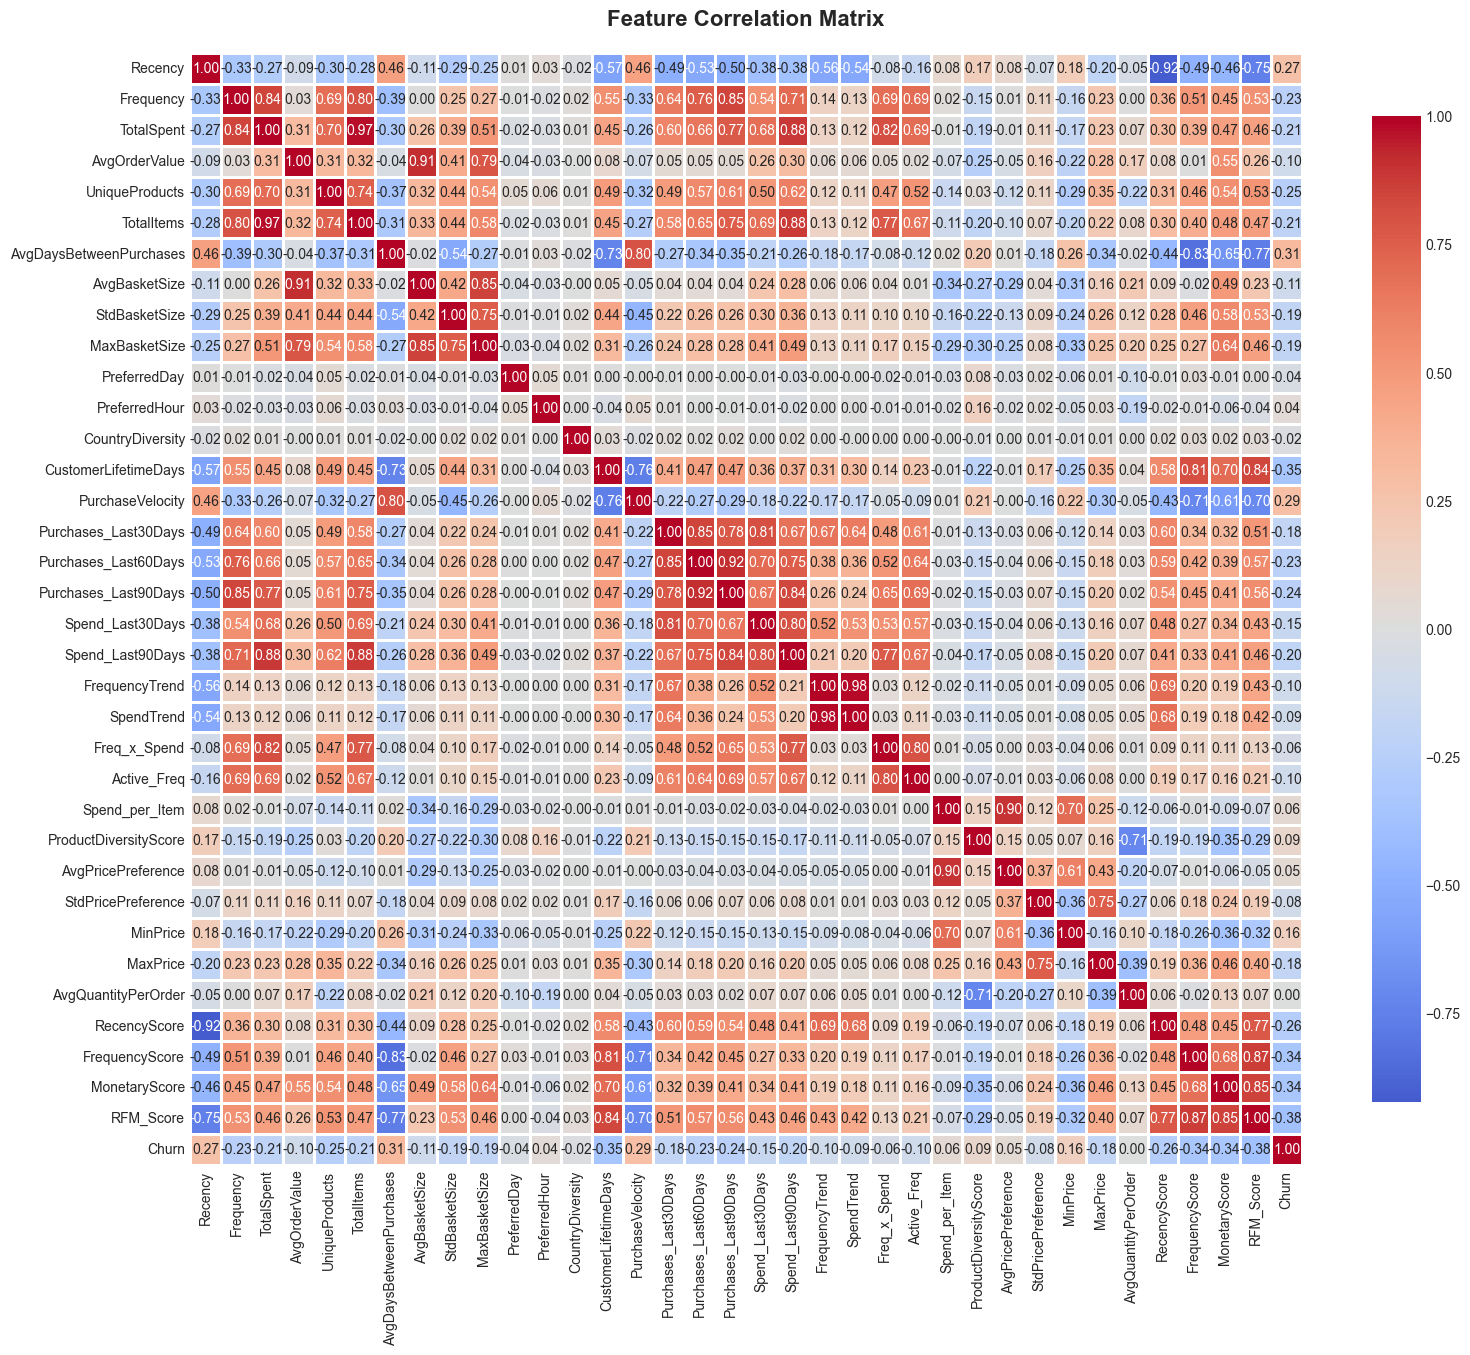


Top 10 Correlations with Churn:
Churn                      1.000000
AvgDaysBetweenPurchases    0.311355
PurchaseVelocity           0.285970
Recency                    0.268307
MinPrice                   0.159012
ProductDiversityScore      0.088084
Spend_per_Item             0.059005
AvgPricePreference         0.052601
PreferredHour              0.035040
AvgQuantityPerOrder        0.000128
CountryDiversity          -0.021326
Name: Churn, dtype: float64

✓ Correlation analysis completed


In [5]:
# Select numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Customer ID']

# Calculate correlation
correlation = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.savefig('../visualizations/eda/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show top correlations with Churn
churn_corr = correlation['Churn'].sort_values(ascending=False)
print('\nTop 10 Correlations with Churn:')
print(churn_corr.head(11))  # 11 because Churn correlates with itself

print('\n✓ Correlation analysis completed')

## 5. Statistical Tests (T-Tests)

In [6]:
# Perform t-tests for all numeric features
churned = df[df['Churn'] == 1]
active = df[df['Churn'] == 0]

ttest_results = []

for feature in numeric_cols:
    if feature == 'Churn':
        continue
    
    t_stat, p_value = stats.ttest_ind(churned[feature], active[feature])
    
    ttest_results.append({
        'Feature': feature,
        'Churned_Mean': churned[feature].mean(),
        'Active_Mean': active[feature].mean(),
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values('P_Value')

print('Statistical Significance Tests (T-Tests):')
print('='*80)
print(ttest_df.to_string(index=False))

# Count significant features
significant_count = (ttest_df['P_Value'] < 0.05).sum()
print(f'\nStatistically Significant Features (p < 0.05): {significant_count}')

#Save results
ttest_df.to_csv('../visualizations/eda/statistical_tests.csv', index=False)
print('\n✓ Statistical tests completed and saved')

Statistical Significance Tests (T-Tests):
                Feature  Churned_Mean  Active_Mean  T_Statistic       P_Value Significant
              RFM_Score      6.264749     8.401185   -23.152549 8.400931e-110         Yes
   CustomerLifetimeDays     49.550885   116.378568   -21.170767  3.146773e-93         Yes
          MonetaryScore      2.053835     2.824987   -20.528321  4.296248e-88         Yes
         FrequencyScore      2.056785     2.822833   -20.374823  6.953474e-87         Yes
AvgDaysBetweenPurchases    593.354142   303.330671    18.565993  3.594111e-73         Yes
       PurchaseVelocity      0.638646     0.334057    16.910905  1.594710e-61         Yes
                Recency    117.472714    75.870221    15.782483  4.217714e-54         Yes
           RecencyScore      2.154130     2.753366   -15.552669  1.212331e-52         Yes
         UniqueProducts     29.495575    62.041465   -14.512602  2.849085e-46         Yes
   Purchases_Last90Days      0.573009     1.487345   -13.8

## 6. Customer Segment Analysis

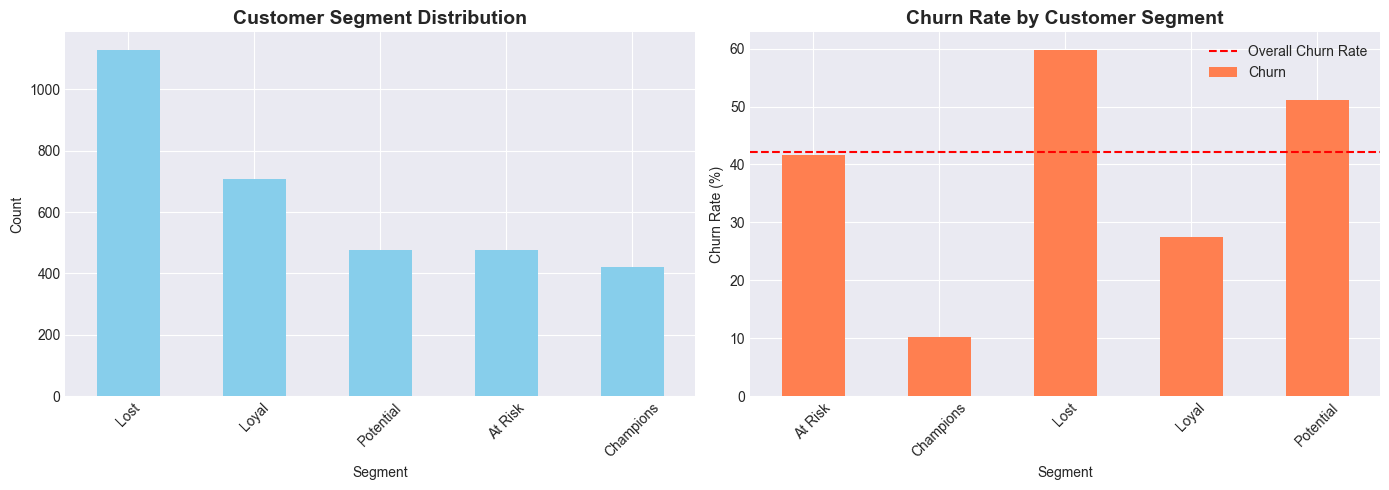

Churn Rate by Segment:
CustomerSegment
Lost         59.823009
Potential    51.153040
At Risk      41.596639
Loyal        27.542373
Champions    10.189573
Name: Churn, dtype: float64

✓ Segment analysis completed


In [7]:
# Segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall segment distribution
segment_counts = df['CustomerSegment'].value_counts()
segment_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Customer Segment Distribution', fontsize=14, weight='bold')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Churn rate by segment
churn_by_segment = df.groupby('CustomerSegment')['Churn'].mean() * 100
churn_by_segment.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Churn Rate by Customer Segment', fontsize=14, weight='bold')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=df['Churn'].mean()*100, color ='r', linestyle='--', label='Overall Churn Rate')
axes[1].legend()

plt.tight_layout()
plt.savefig('../visualizations/eda/04_segment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('Churn Rate by Segment:')
print(churn_by_segment.sort_values(ascending=False))
print('\n✓ Segment analysis completed')

## 7. Temporal Patterns

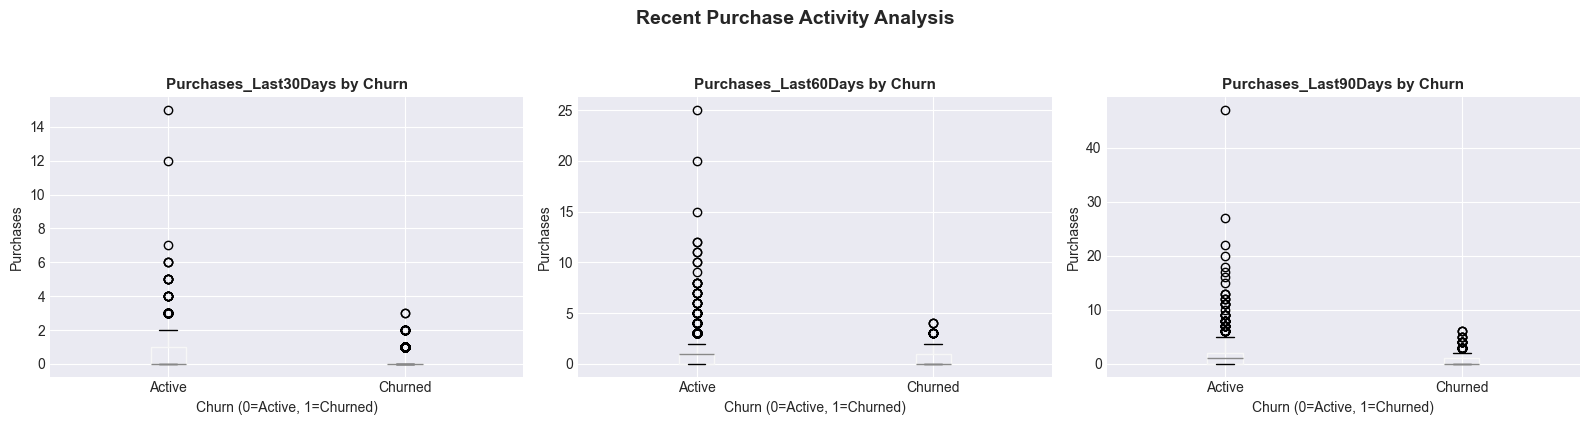

✓ Temporal analysis completed


In [8]:
# Recent activity patterns
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

recent_features = ['Purchases_Last30Days', 'Purchases_Last60Days', 'Purchases_Last90Days']

for idx, feature in enumerate(recent_features):
    df.boxplot(column=feature, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Churn', fontsize=11, weight='bold')
    axes[idx].set_xlabel('Churn (0=Active, 1=Churned)')
    axes[idx].set_ylabel('Purchases')
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['Active', 'Churned'])

plt.suptitle('Recent Purchase Activity Analysis', fontsize=14, weight='bold', y=1.05)
plt.tight_layout()
plt.savefig('../visualizations/eda/05_temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Temporal analysis completed')

## 8. Key Insights Summary

In [9]:
print('='*80)
print('KEY EDA INSIGHTS')
print('='*80)

print('\n1. CHURN DISTRIBUTION:')
print(f'   - Churn Rate: {df["Churn"].mean()*100:.2f}%')
print(f'   - Churned: {df["Churn"].sum():,} customers')
print(f'   - Active: {(1-df["Churn"]).sum():,} customers')

print('\n2. MOST SIGNIFICANT FEATURES (p < 0.001):')
top_significant = ttest_df[ttest_df['P_Value'] < 0.001].head(5)
for _, row in top_significant.iterrows():
    print(f'   - {row["Feature"]}: p-value = {row["P_Value"]:.6f}')

print('\n3. RFM PATTERNS:')
print(f'   - Recency difference: {churned["Recency"].mean():.1f} vs {active["Recency"].mean():.1f} days')
print(f'   - Frequency difference: {churned["Frequency"].mean():.1f} vs {active["Frequency"].mean():.1f} purchases')
print(f'   - Spending difference: £{churned["TotalSpent"].mean():.2f} vs £{active["TotalSpent"].mean():.2f}')

print('\n4. CUSTOMER SEGMENTS:')
for segment in churn_by_segment.sort_values(ascending=False).index:
    rate = churn_by_segment[segment]
    count = df[df['CustomerSegment'] == segment].shape[0]
    print(f'   - {segment}: {rate:.1f}% churn rate ({count} customers)')

print('\n' + '='*80)

KEY EDA INSIGHTS

1. CHURN DISTRIBUTION:
   - Churn Rate: 42.20%
   - Churned: 1,356 customers
   - Active: 1,857 customers

2. MOST SIGNIFICANT FEATURES (p < 0.001):
   - RFM_Score: p-value = 0.000000
   - CustomerLifetimeDays: p-value = 0.000000
   - MonetaryScore: p-value = 0.000000
   - FrequencyScore: p-value = 0.000000
   - AvgDaysBetweenPurchases: p-value = 0.000000

3. RFM PATTERNS:
   - Recency difference: 117.5 vs 75.9 days
   - Frequency difference: 2.0 vs 4.5 purchases
   - Spending difference: £448.91 vs £1204.92

4. CUSTOMER SEGMENTS:
   - Lost: 59.8% churn rate (1130 customers)
   - Potential: 51.2% churn rate (477 customers)
   - At Risk: 41.6% churn rate (476 customers)
   - Loyal: 27.5% churn rate (708 customers)
   - Champions: 10.2% churn rate (422 customers)

